In [1]:
import numpy as np
from jesse import helpers, research

_, trading_1m = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-04-30"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

trading_1m.shape


(2802240, 6)

In [2]:
np.save("data/btc_1m.npy", trading_1m)

In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

(2802240, 6)

In [2]:
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe

df = numpy_candles_to_dataframe(candles)
df["hlret"] = np.log(df["high"] / df["low"])
ret_list = []
for i in range(1, 150):
    ret_series = np.log(df["close"] / df["close"].shift(i))
    ret_series.name = f"ret{i}"
    ret_list.append(ret_series)
df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list
df = df[df["ret149"].notna()]
df.head()

,date,open,close,high,low,volume,hlret,ret1,ret2,ret3,...,ret140,ret141,ret142,ret143,ret144,ret145,ret146,ret147,ret148,ret149
2020-01-01 02:29:00,2020-01-01 02:29:00,7233.19,7228.09,7233.57,7225.76,7.972429,0.001080,-0.000774,-0.000790,-0.000098,...,0.005135,0.005606,0.006166,0.006397,0.006677,0.006706,0.005848,0.006337,0.006114,0.005746
2020-01-01 02:30:00,2020-01-01 02:30:00,7227.12,7232.89,7233.14,7226.79,4.631254,0.000878,0.000664,-0.000111,-0.000126,...,0.006315,0.005799,0.006270,0.006830,0.007061,0.007341,0.007370,0.006512,0.007001,0.006778
2020-01-01 02:31:00,2020-01-01 02:31:00,7232.35,7231.50,7233.84,7229.47,13.106277,0.000604,-0.000192,0.000472,-0.000303,...,0.005935,0.006123,0.005607,0.006078,0.006637,0.006869,0.007148,0.007178,0.006320,0.006809
2020-01-01 02:32:00,2020-01-01 02:32:00,7231.69,7232.77,7233.14,7229.78,18.132154,0.000465,0.000176,-0.000017,0.000647,...,0.006345,0.006110,0.006298,0.005782,0.006254,0.006813,0.007044,0.007324,0.007353,0.006496
2020-01-01 02:33:00,2020-01-01 02:33:00,7232.06,7231.68,7236.07,7230.19,10.299170,0.000813,-0.000151,0.000025,-0.000167,...,0.006882,0.006195,0.005960,0.006147,0.005631,0.006103,0.006662,0.006893,0.007173,0.007203


所有交点： [-0.027322520087495996, -0.005046562879228794, 0.005478744069426195, 0.02787277790240389]


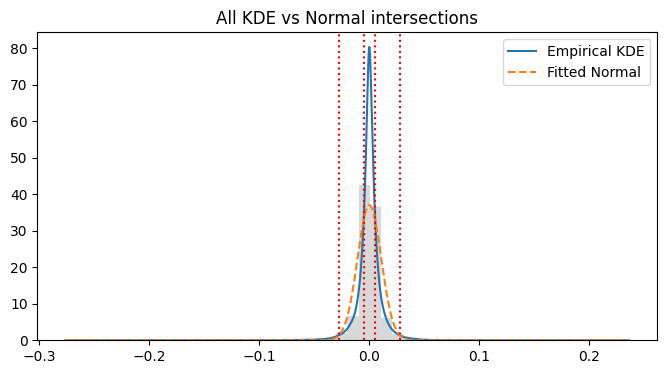

In [3]:
from custom_indicators.utils.plot import find_kde_cross

target = df["ret149"].to_numpy()
roots = find_kde_cross(target)

In [4]:
series = df["ret149"].copy().sort_values()
label = ((series <= roots[0]) | (series >= roots[-1])).astype(int)
label.sort_index(inplace=True)
label.value_counts()

ret149
0    2721888
1      80203
Name: count, dtype: int64

In [5]:
import numpy as np
from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicClassifier
from sklearn.metrics import f1_score


def gp_f1(y, y_pred, w):
    y_pred_labels = (y_pred > 0.5).astype(int)
    return f1_score(y, y_pred_labels, sample_weight=w)


my_custom_f1_fitness = make_fitness(function=gp_f1, greater_is_better=True)

cols = [f"ret{i}" for i in range(1, 150)] + ["hlret"]

est_gp = SymbolicClassifier(
    metric=my_custom_f1_fitness,
    population_size=5000,
    stopping_criteria=0,
    function_set=["add", "sub", "sqrt", "log", "abs", "neg", "max", "min"],
    p_crossover=0.7,
    p_subtree_mutation=0.05,
    p_hoist_mutation=0.05,
    p_point_mutation=0.05,
    max_samples=1,
    parsimony_coefficient=0.005,
    class_weight="balanced",
    feature_names=cols,
    verbose=1,
    n_jobs=-1,
)


est_gp.fit(df[cols], label)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


KeyboardInterrupt: 

In [6]:
label_pred = est_gp.predict(df[cols])

In [7]:
np.unique(label_pred, return_counts=True)

(array([0, 1]), array([1853279,  948812]))

In [20]:
from scipy import stats

for lag in range(10, 300):
    log_ret = np.log(candles[lag:, 2] / candles[:-lag, 2])
    standard = (log_ret - log_ret.mean()) / log_ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    print(f"{lag = }: {kurtosis = }")


lag = 10: kurtosis = 125.04079440674127
lag = 11: kurtosis = 120.46570093720588
lag = 12: kurtosis = 117.56002986981134
lag = 13: kurtosis = 117.51119822077509
lag = 14: kurtosis = 118.70541440617576
lag = 15: kurtosis = 118.56846043973552
lag = 16: kurtosis = 117.39264738880478
lag = 17: kurtosis = 116.55392525758681
lag = 18: kurtosis = 115.07521311912788
lag = 19: kurtosis = 111.09566062478092
lag = 20: kurtosis = 108.08510562174398
lag = 21: kurtosis = 108.05299135360674
lag = 22: kurtosis = 107.7372307798711
lag = 23: kurtosis = 107.74103744274898
lag = 24: kurtosis = 106.43423258494815
lag = 25: kurtosis = 102.8088049501738
lag = 26: kurtosis = 100.13844976152821
lag = 27: kurtosis = 97.64221819520611
lag = 28: kurtosis = 95.85058536785954
lag = 29: kurtosis = 94.02282964815939
lag = 30: kurtosis = 91.7026866189541
lag = 31: kurtosis = 89.15452511398772
lag = 32: kurtosis = 86.78972437197557
lag = 33: kurtosis = 84.73163305340113
lag = 34: kurtosis = 83.14676385794016
lag = 35: k

In [15]:
import os
from multiprocessing import Pool

from tqdm.auto import tqdm

from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy

LAG = 159
log_ret = [
    np.log(candles[i, 2] / candles[-LAG + i : i, 2]) for i in range(LAG, len(candles))
]
with Pool(processes=os.cpu_count() - 1) as pool:
    entropy_array = list(
        tqdm(pool.imap(sample_entropy, log_ret), total=len(log_ret), desc="计算样本熵")
    )

candles = candles[LAG:]

计算样本熵:   0%|          | 0/2802081 [00:00<?, ?it/s]

In [16]:
# 计算threshold
DURATION = 298

threshold = np.sum(entropy_array) / (len(candles) // DURATION)
threshold

22.13884657559276

In [17]:
from custom_indicators.toolbox.bar.build import build_bar_by_cumsum

merged_bar = build_bar_by_cumsum(candles, entropy_array, threshold)
merged_bar.shape

(9383, 6)

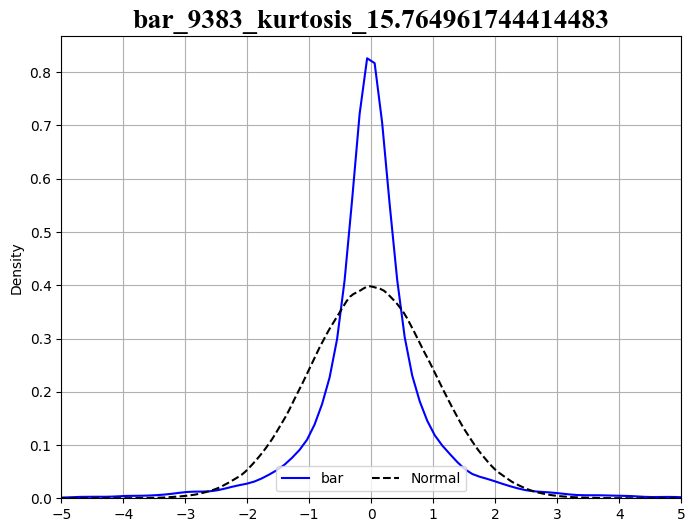

In [18]:
from custom_indicators.utils.plot import plot_kde

plot_kde(merged_bar[:, 2])

In [2]:
import numpy as np

np.flip((np.arange(1, 10 + 1) / 10))


array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

In [1]:
import os
from multiprocessing import Pool

import jesse.indicators as ta
import numpy as np
import optuna
from scipy import stats

from custom_indicators.toolbox.bar.build import build_bar_by_cumsum
from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy

raw_candles = np.load("data/btc_1m.npy")


def objective(trial, raw_candles=raw_candles):
    duration = trial.suggest_int("duration", 60, 360)
    lag = trial.suggest_int("lag", 20, 360)
    use_weight = trial.suggest_categorical("use_weight", [True, False])
    use_heikin_ashi = trial.suggest_categorical("use_heikin_ashi", [True, False])
    if use_heikin_ashi:
        candles = ta.heikin_ashi_candles(raw_candles, sequential=True)
    else:
        candles = raw_candles

    log_ret = np.asarray(
        [
            np.log(candles[i, 2] / candles[-lag + i : i, 2])
            for i in range(lag, len(candles))
        ]
    )
    if use_weight:
        weight = np.flip(np.arange(1, len(log_ret) + 1) / len(log_ret))
    else:
        weight = np.ones(len(log_ret))
    log_ret = log_ret * weight

    with Pool(processes=os.cpu_count() - 1) as pool:
        entropy_array = list(pool.map(sample_entropy, log_ret))
    candles = candles[lag:]

    threshold = np.sum(entropy_array) / (len(candles) // duration)
    merged_bar = build_bar_by_cumsum(candles, entropy_array, threshold)
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis


study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=500, n_jobs=1)

[I 2025-05-10 09:13:44,424] A new study created in memory with name: no-name-a9ef4ca5-dbfb-4180-9d79-988f20eb0fd3
[I 2025-05-10 09:14:35,946] Trial 0 finished with value: 32.157646466390474 and parameters: {'duration': 121, 'lag': 56}. Best is trial 0 with value: 32.157646466390474.
[I 2025-05-10 09:25:49,775] Trial 1 finished with value: 38.81018842212474 and parameters: {'duration': 75, 'lag': 248}. Best is trial 0 with value: 32.157646466390474.
[I 2025-05-10 09:32:42,610] Trial 2 finished with value: 26.590571473154142 and parameters: {'duration': 177, 'lag': 193}. Best is trial 2 with value: 26.590571473154142.
[I 2025-05-10 09:45:13,006] Trial 3 finished with value: 30.263226802029685 and parameters: {'duration': 250, 'lag': 258}. Best is trial 2 with value: 26.590571473154142.
[I 2025-05-10 09:52:05,611] Trial 4 finished with value: 39.48085496974485 and parameters: {'duration': 114, 'lag': 196}. Best is trial 2 with value: 26.590571473154142.
[I 2025-05-10 09:52:57,078] Trial 5

In [9]:
from custom_indicators.toolbox.bar.dollar_bar import (
    build_dollar_bar,
)

DOLLAR_BAR_THRESHOLD_SHORT = 879486036.3109347
DOLLAR_BAR_THRESHOLD_MID = 2638458106.932804
DOLLAR_BAR_THRESHOLD_LONG = 7974006721.152473

dollar_bar = build_dollar_bar(candles, DOLLAR_BAR_THRESHOLD_MID)
dollar_bar.shape


(1783, 6)

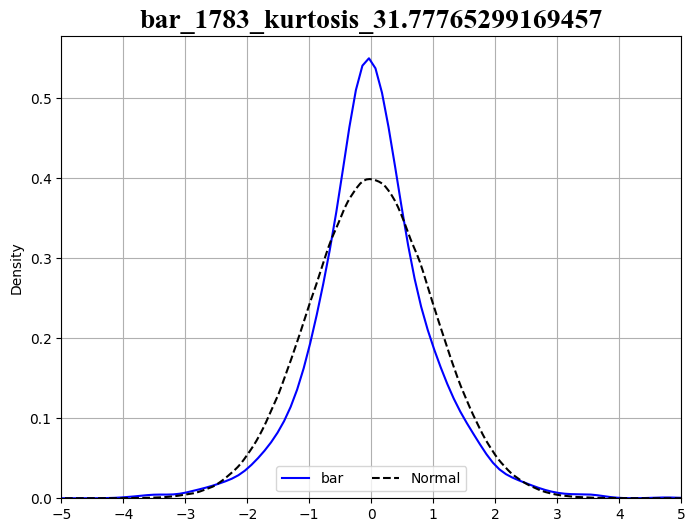

In [10]:
from custom_indicators.utils.plot import plot_kde

plot_kde(dollar_bar[:, 2])

In [ ]:
from pathlib import Path

from custom_indicators.toolbox.bar.merge import np_merge_bars

N = int(candles.shape[0] / 240)

for lag in [100, 140, 145, 146, 147, 148, 149, 150, 151, 160, 200, 250]:
    print(f"------------------{lag = }---------------------")
    if not Path(f"data/btc_1m_m4h_lag_{lag}.npy").exists():
        new_candles = np_merge_bars(candles, N, lag=lag)
        print(new_candles.shape)
        np.save(f"data/btc_1m_m4h_lag_{lag}.npy", new_candles)

------------------lag = 100---------------------


In [2]:
from pathlib import Path

from custom_indicators.toolbox.bar.merge import np_merge_bars

for t in [-10, 10]:
    print(f"------------------{t = }---------------------")
    N = int(candles.shape[0] / (4 * 60 + t))
    path = Path(f"data/btc_1m_m4h{t}_lag_149.npy")
    if not path.exists():
        new_candles = np_merge_bars(candles, N, lag=149)
        print(new_candles.shape)
        np.save(path, new_candles)


------------------t = -10---------------------
n = 2750000, target = 12152
n = 2700000, target = 12152
n = 2650000, target = 12152
n = 2600000, target = 12152
n = 2550000, target = 12152
n = 2500000, target = 12152
n = 2450000, target = 12152
n = 2400000, target = 12152
n = 2350000, target = 12152
n = 2300000, target = 12152
n = 2250000, target = 12152
n = 2200000, target = 12152
n = 2150000, target = 12152
n = 2100000, target = 12152
n = 2050000, target = 12152
n = 2000000, target = 12152
n = 1950000, target = 12152
n = 1900000, target = 12152
n = 1850000, target = 12152
n = 1800000, target = 12152
n = 1750000, target = 12152
n = 1700000, target = 12152
n = 1650000, target = 12152
n = 1600000, target = 12152
n = 1550000, target = 12152
n = 1500000, target = 12152
n = 1450000, target = 12152
n = 1400000, target = 12152
n = 1350000, target = 12152
n = 1300000, target = 12152
n = 1250000, target = 12152
n = 1200000, target = 12152
n = 1150000, target = 12152
n = 1100000, target = 12152
n

In [1]:
import numpy as np
from jesse.utils import numpy_candles_to_dataframe

merged_bar = np.load("data/btc_1m_m4h_lag_149.npy")
df_merged_bar = numpy_candles_to_dataframe(merged_bar)
df_merged_bar.head()

,date,open,close,high,low,volume
2020-04-23 14:04:00,2020-04-23 14:04:00,7233.19,7288.22,10500.0,3782.13,8.900527e+06
2020-04-23 14:05:00,2020-04-23 14:05:00,7287.95,7338.21,7370.0,7286.04,2.087391e+03
2020-04-23 14:06:00,2020-04-23 14:06:00,7338.21,7333.15,7353.0,7320.00,6.119475e+02
2020-04-23 14:07:00,2020-04-23 14:07:00,7333.12,7349.65,7349.9,7330.63,4.029516e+02
2020-04-23 14:08:00,2020-04-23 14:08:00,7347.11,7365.01,7383.0,7344.37,5.985218e+02


In [2]:
from lightweight_charts import Chart

chart = Chart()
chart.set(df_merged_bar[["date", "open", "high", "low", "close", "volume"]])
chart.show(block=True)


RuntimeError: asyncio.run() cannot be called from a running event loop

(11646, 6)


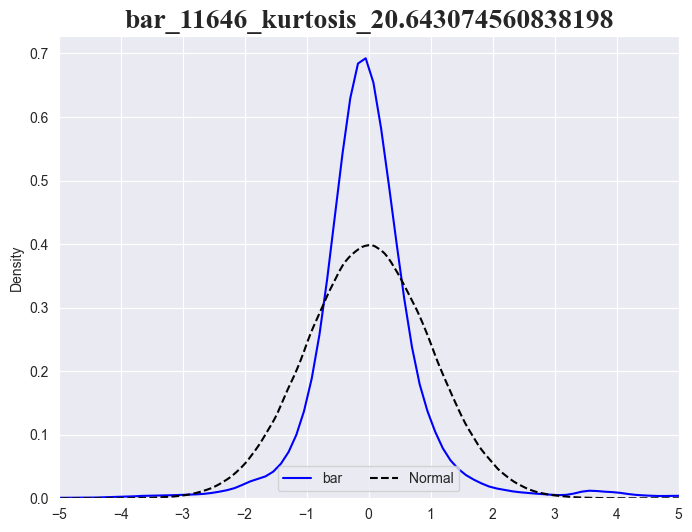

In [3]:
"""
lag 100: kurtosis = 46.53
lag 140: kurtosis = 21.92
lag 147: kurtosis = 21.76
lag 148: kurtosis = 21.01
lag 149: kurtosis = 20.64
lag 150: kurtosis = 20.95
lag 160: kurtosis = 24.14
lag 200: kurtosis = 33.81
"""

merged_bar = np.load("data/btc_1m_m4h_lag_149.npy")
print(merged_bar.shape)
plot_kde(merged_bar[:, 2], lag=1)